# Calculates Associated Difference Spectrum

## Objective
1. Calculates Decay Associated Difference Spectrum
2. Evaluates Species Associated Difference Spectrum
3. Understand SADS is just linear combination of DADS


In this example, we only deal with gaussian irf 

In [1]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
import TRXASprefitpack
from TRXASprefitpack import solve_seq_model, compute_signal_gau
from TRXASprefitpack import voigt 
from TRXASprefitpack import dads, sads
plt.rcParams["figure.figsize"] = (12,9)

## Version information

In [2]:
print(TRXASprefitpack.__version__)

0.7.0


In [3]:
# Generates fake experiment data
# Model: 1 -> 2 -> 3 -> GS
# lifetime 
# tau1: 0.3 ps
# tau2: 500 ps 
# tau3: 10 ns
# fwhm paramter of gaussian IRF: 100 fs

# generates model spectrum

e = np.arange(2015, 2030.25, 0.25)

gs = voigt(e-2025, 0.2, 2)
ex_1 = 0.7*voigt(e-2027, 0.2, 2) + 0.3*voigt(e-2025, 0.2, 2)
ex_2 = 0.6*voigt(e-2025.5, 0.2, 2) + 0.2*voigt(e-2023.5, 0.2, 2) + \
    0.2*voigt(e-2021.5, 0.2, 2)
ex_3 = 0.995*voigt(e-2025.15, 0.2, 2)

# Model difference spectrum
model_diff_abs = \
    np.vstack((ex_1-gs, ex_2-gs, ex_3-gs, np.zeros_like(gs))).T

tau_1 = 0.3
tau_2 = 500
tau_3 = 10000
fwhm = 0.10

# initial condition
y0 = np.array([1, 0, 0, 0])

# set time range (mixed step)
t1 = np.arange(-2, -1, 0.1)
t2 = np.arange(-1, 1, 0.05)
t3 = np.arange(1, 2, 0.1)
t4 = np.arange(2, 4, 0.5)
t5 = np.arange(4, 8, 1)
t6 = np.arange(8, 16, 2)
t7 = np.arange(16, 32, 4)
t8 = np.arange(32, 64, 8)
t9 = np.arange(64, 128, 16)
t10 = np.arange(128, 256, 32)
t11 = np.arange(256, 512, 64)
t12 = np.arange(512, 1024, 128)
t13 = np.arange(1024, 2048, 256)
t14 = np.array([2048])

t = np.hstack((t1, t2, t3, t4,
t5, t6, t7, t8,
t9, t10, t11, t12,
t13, t14))

eigval_seq, V_seq, c_seq = solve_seq_model(np.array([tau_1, tau_2, tau_3]), y0)

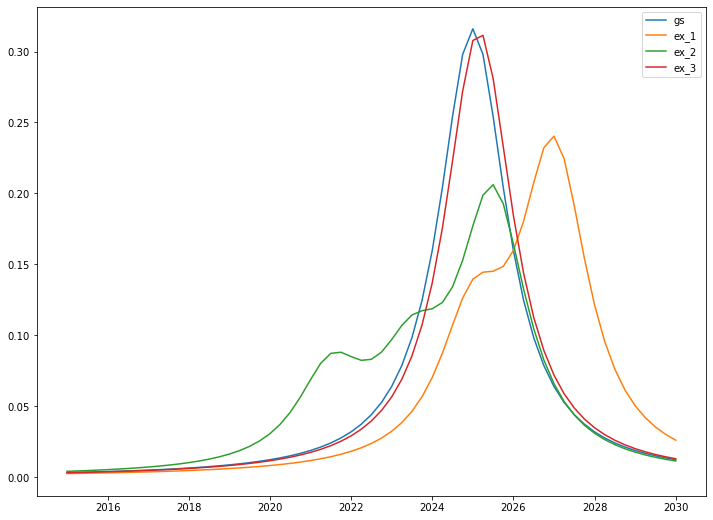

In [4]:
plt.plot(e, gs, label='gs')
plt.plot(e, ex_1, label='ex_1')
plt.plot(e, ex_2, label='ex_2')
plt.plot(e, ex_3, label='ex_3')
plt.legend()
plt.show()

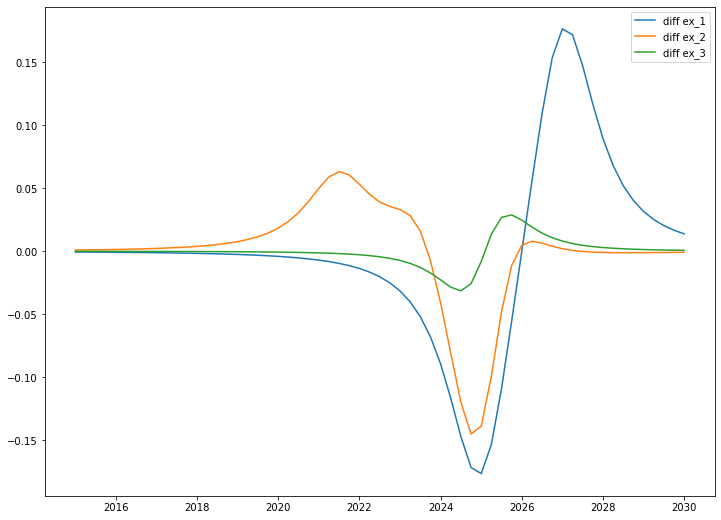

In [5]:
plt.plot(e, ex_1-gs, label='diff ex_1')
plt.plot(e, ex_2-gs, label='diff ex_2')
plt.plot(e, ex_3-gs, label='diff ex_3')
plt.legend()
plt.show()

In [6]:


# Now select time scan energy
tscan_energy = np.array([2021.5, 2023.45, 2025, 2027])
model_diff_slec = model_diff_abs[np.searchsorted(e, tscan_energy), :]

t0 = np.random.normal(0, fwhm, 1) # perturb time zero

y_model_tscan = compute_signal_gau(t-t0[0], fwhm, 
eigval_seq, V_seq, c_seq)

# generate measured data time scan data
model_tscan = (model_diff_slec @ y_model_tscan).T

# Next select energy scan time
escan_time = np.array([0.1, 0.5, 1, 128, 512, 1024])
y_model_escan = compute_signal_gau(escan_time-t0[0], fwhm,
eigval_seq, V_seq, c_seq)
model_escan = model_diff_abs @ y_model_escan

# generate random noise
eps_escan = 0.005*np.ones_like(model_escan)
eps_tscan = 0.005*np.ones_like(model_tscan)

# generate random noise
noise_escan = \
    np.random.normal(0, 0.005, model_escan.shape)
noise_tscan = \
    np.random.normal(0, 0.005, model_tscan.shape)

# generate measured intensity
i_obs_escan = model_escan + noise_escan
i_obs_tscan = model_tscan + noise_tscan

# print real values

print('-'*24)
print(f'fwhm: {fwhm}')
print(f'tau_1: {tau_1}')
print(f'tau_2: {tau_2}')
print(f'tau_3: {tau_3}')
print(f'time_zero: {t0[0]: .4f}')

param_exact = [fwhm, t0[0], tau_1, tau_2, tau_3]

------------------------
fwhm: 0.1
tau_1: 0.3
tau_2: 500
tau_3: 10000
time_zero: -0.0497


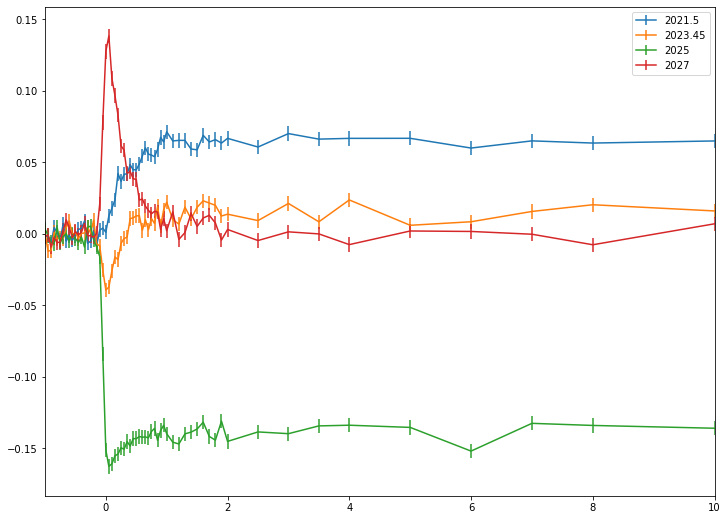

In [7]:
# plot model experimental data (tscan)
plt.figure(1)
plt.errorbar(t, i_obs_tscan[:, 0], eps_tscan[:, 0], label='2021.5')
plt.errorbar(t, i_obs_tscan[:, 1], eps_tscan[:, 1], label='2023.45')
plt.errorbar(t, i_obs_tscan[:, 2], eps_tscan[:, 2], label='2025')
plt.errorbar(t, i_obs_tscan[:, 3], eps_tscan[:, 3], label='2027')
plt.legend()
plt.xlim(-1, 10)
plt.show()

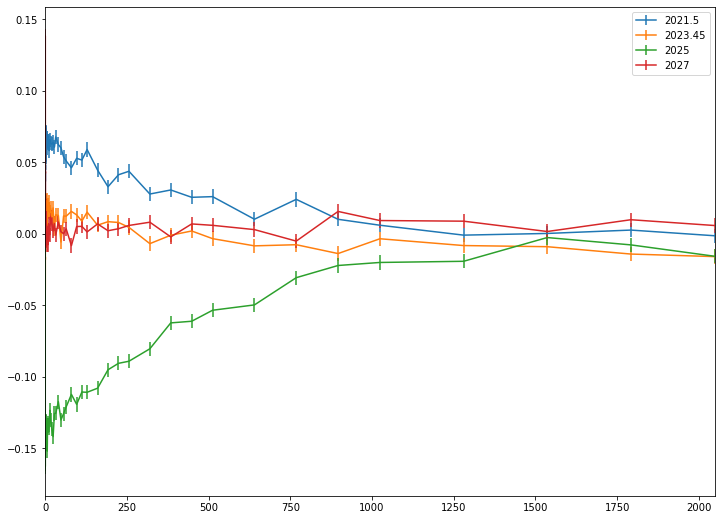

In [8]:
plt.figure(2)
plt.errorbar(t, i_obs_tscan[:, 0], eps_tscan[:, 0], label='2021.5')
plt.errorbar(t, i_obs_tscan[:, 1], eps_tscan[:, 1], label='2023.45')
plt.errorbar(t, i_obs_tscan[:, 2], eps_tscan[:, 2], label='2025')
plt.errorbar(t, i_obs_tscan[:, 3], eps_tscan[:, 3], label='2027')
plt.legend()
plt.xlim(-1, 2048)
plt.show()

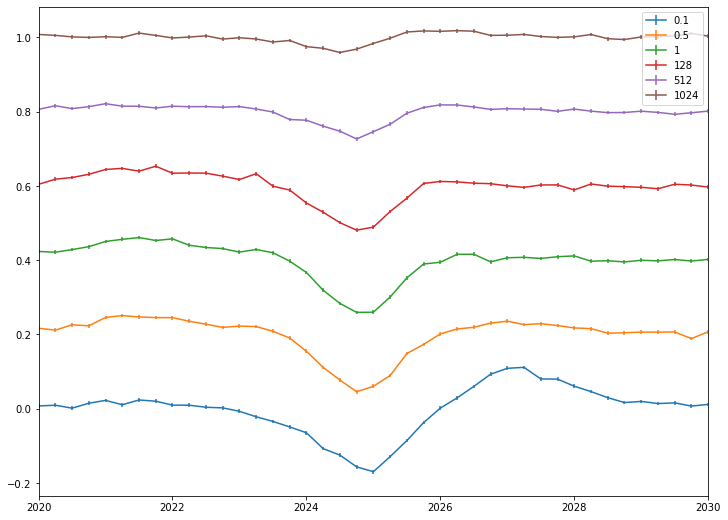

In [9]:
# plot model experimental data (escan)
plt.figure(3)
plt.errorbar(e, i_obs_escan[:, 0], eps_escan[:, 0], label='0.1')
plt.errorbar(e, i_obs_escan[:, 1]+0.2, eps_escan[:, 1], label='0.5')
plt.errorbar(e, i_obs_escan[:, 2]+0.4, eps_escan[:, 2], label='1')
plt.errorbar(e, i_obs_escan[:, 3]+0.6, eps_escan[:, 3], label='128')
plt.errorbar(e, i_obs_escan[:, 4]+0.8, eps_escan[:, 4], label='512')
plt.errorbar(e, i_obs_escan[:, 5]+1.0, eps_escan[:, 5], label='1024')
plt.legend()
plt.xlim(2020, 2030)
plt.show()

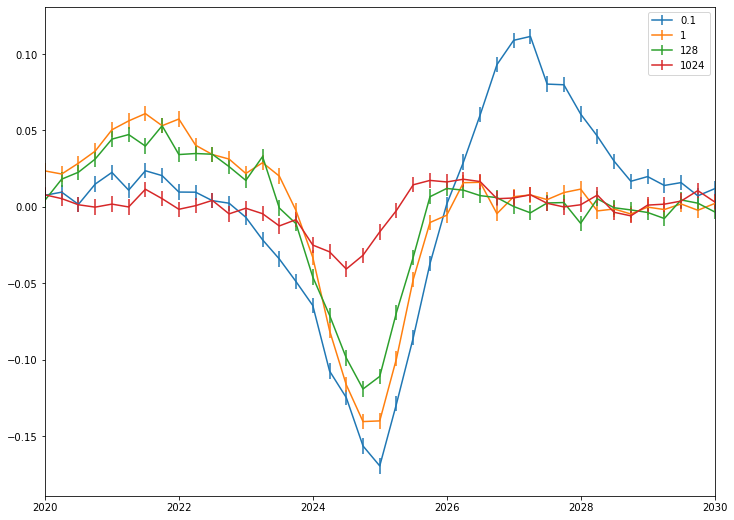

In [10]:
plt.figure(4)
plt.errorbar(e, i_obs_escan[:, 0], eps_escan[:, 0], label='0.1')
plt.errorbar(e, i_obs_escan[:, 2], eps_escan[:, 2], label='1')
plt.errorbar(e, i_obs_escan[:, 3], eps_escan[:, 3], label='128')
plt.errorbar(e, i_obs_escan[:, 5], eps_escan[:, 5], label='1024')
plt.legend()
plt.xlim(2020, 2030)
plt.show()

## Find decay component from time trace fitting
Based on time delay scan and energy scan data, there is at least three species in our model dynamics.
Which is corresponding to `0.5`, `300` and long lived.

In [11]:
# import needed module for fitting
from TRXASprefitpack import fit_transient_exp

# time, intensity, eps should be sequence of numpy.ndarray
t_lst = [t] 
intensity = [i_obs_tscan]
eps = [eps_tscan]

# set initial guess
irf = 'g' # shape of irf function
fwhm_init = 0.15
# four time scan have same time zero
t0_init = np.array([0])
# test with one decay module
tau_init = np.array([0.5, 300])

# use global optimization method: AMPGO
# set base: True to approximate long lived decay
# set same_t0 : True (i.e. all four time delay scan have same time zero)
fit_result = fit_transient_exp(irf, fwhm_init, t0_init, tau_init, True, 
method_glb='ampgo', kwargs_lsq={'verbose' : 2},
same_t0=True, t=t_lst, intensity=intensity, eps=eps)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9261e+02                                    5.29e-04    
       1              2         1.9261e+02      1.03e-11       8.52e-05       4.61e-06    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9261e+02, final cost 1.9261e+02, first-order optimality 4.61e-06.


In [12]:
# print fitting result
print(fit_result)

[Model information]
    model : decay
    irf: g
    fwhm:  0.0991
    eta:  0.0000
    base: True
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 1181
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: `ftol` termination condition is satisfied.
 
[Optimization Results]
    Total Data points: 404
    Number of effective parameters: 16
    Degree of Freedom: 388
    Chi squared:  385.2192
    Reduced chi squared:  0.9928
    AIC (Akaike Information Criterion statistic):  12.7686
    BIC (Bayesian Information Criterion statistic):  76.7913
 
[Parameters]
    fwhm_G:  0.09909933 +/-  0.00644943 ( 6.51%)
    t_0_0: -0.04865283 +/-  0.00208223 ( 4.28%)
    tau_1:  0.29472106 +/-  0.01162710 ( 3.95%)
    tau_2:  506.87135609 +/-  26.29547839 ( 5.19%)
 
[Parameter Bound]
    fwhm_G:  0.075 <=  0.09909933 <=  0.3
    t_0_0: -0.3 <= -0.04865283 <=  0.3
    tau_1:  0.075 <=  0.29472106 <=  1.2
    

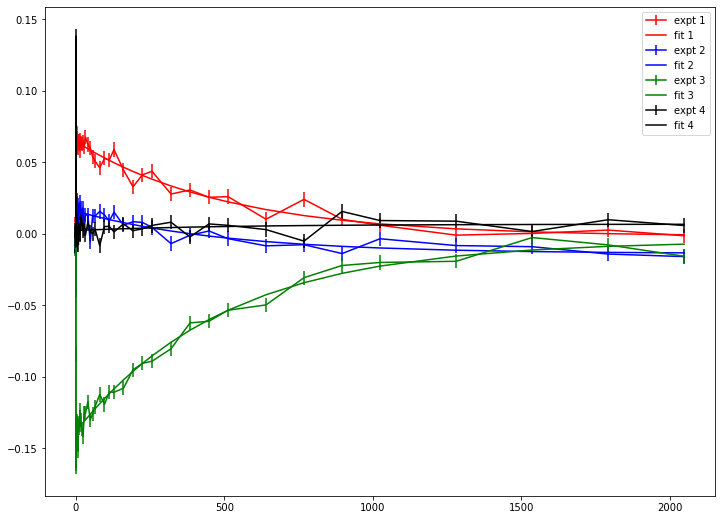

In [13]:
# plot fitting result and experimental data

color_lst = ['red', 'blue', 'green', 'black']
plt.figure(5)
for i in range(4):
    plt.errorbar(t_lst[0], intensity[0][:, i], eps[0][:, i], 
    label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t_lst[0], fit_result['fit'][0][:, i], 
    label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.show()

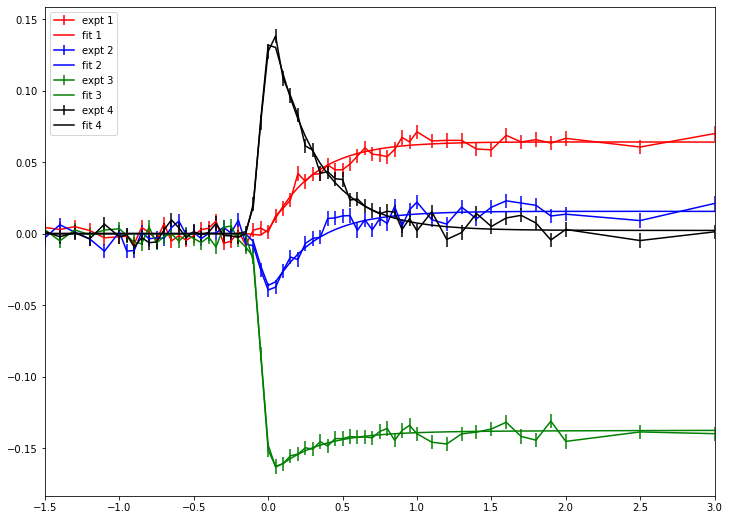

In [14]:
# plot with shorter time range

plt.figure(6)
for i in range(4):
    plt.errorbar(t_lst[0], intensity[0][:, i], eps[0][:, i], 
    label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t_lst[0], fit_result['fit'][0][:, i], 
    label=f'fit {i+1}', color=color_lst[i])

plt.xlim(-10*fwhm_init, 20*fwhm_init)
plt.legend()
plt.show()


## Calulates Associated Difference Spectrum
Now calculates associated difference spectrum.
First, calculates decay associated difference spectrum 

In [15]:
t0_exp = fit_result['x'][1] # estimate time zero of energy scan from time trace fitting result 
fwhm_exp = fit_result['x'][0]
tau_exp = fit_result['x'][2:]
dads_exp, dads_eps, dads_fit = dads(escan_time-t0, 
fit_result['x'][0], tau_exp, True, irf='g', 
intensity=i_obs_escan, eps=eps_escan)


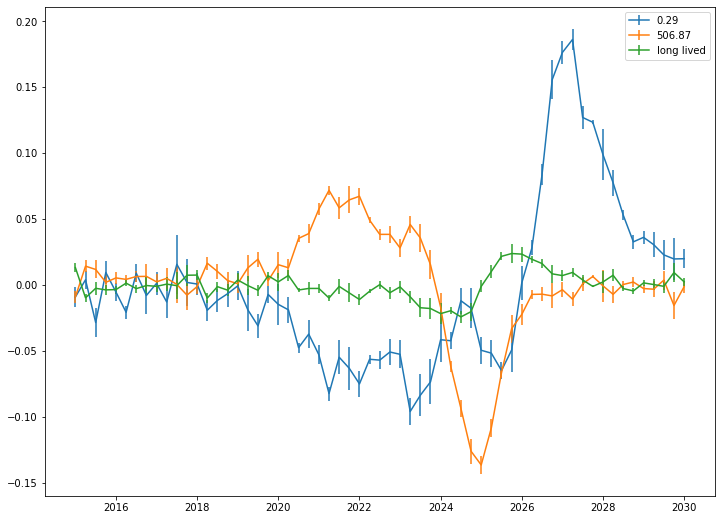

In [16]:
# plot dads

plt.figure(7)
plt.errorbar(e, dads_exp[0, :], dads_eps[0, :], label=f'{tau_exp[0]:.2f}')
plt.errorbar(e, dads_exp[1, :], dads_eps[1, :], label=f'{tau_exp[1]:.2f}')
plt.errorbar(e, dads_exp[2, :], dads_eps[2, :], label='long lived')
plt.legend()
plt.show()

One can retrive energy scan from DADS.

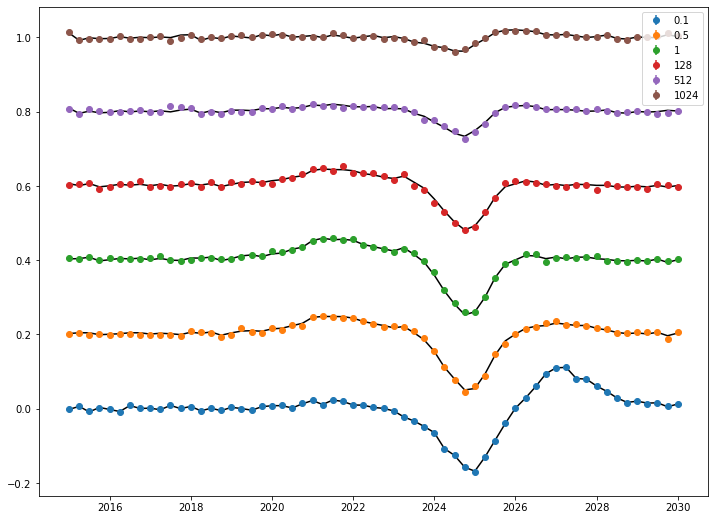

In [17]:
plt.figure(8)
plt.errorbar(e, i_obs_escan[:, 0], eps_escan[:, 0], 
label='0.1', marker='o', linestyle='none')
plt.plot(e, dads_fit[:, 0], color='black')
plt.errorbar(e, i_obs_escan[:, 1]+0.2, eps_escan[:, 1], 
label='0.5', marker='o', linestyle='none')
plt.plot(e, dads_fit[:, 1]+0.2, color='black')
plt.errorbar(e, i_obs_escan[:, 2]+0.4, eps_escan[:, 2], 
label='1', marker='o', linestyle='none')
plt.plot(e, dads_fit[:, 2]+0.4, color='black')
plt.errorbar(e, i_obs_escan[:, 3]+0.6, eps_escan[:, 3], 
label='128', marker='o', linestyle='none')
plt.plot(e, dads_fit[:, 3]+0.6, color='black')
plt.errorbar(e, i_obs_escan[:, 4]+0.8, eps_escan[:, 4], 
label='512', marker='o', linestyle='none')
plt.plot(e, dads_fit[:, 4]+0.8, color='black')
plt.errorbar(e, i_obs_escan[:, 5]+1.0, eps_escan[:, 5], 
label='1024', marker='o', linestyle='none')
plt.plot(e, dads_fit[:, 5]+1.0, color='black')
plt.legend()
plt.show()

DADS well reproduces experimental energy scan result.

However DADS itself does not directly have chemical or physcial meaning.
Now calculates Species Associated Difference Spectrum.
To do so, use squential decay model.

In [18]:
# calculates SADS
y0_exp = np.array([1, 0, 0]) # 1st element: ex1, 2nd element: ex2, 3rd element: ex3
eigval_exp, V_exp, c_exp = solve_seq_model(tau_exp, y0)
sads_exp, sads_err, sads_fit = sads(escan_time-t0_exp, fwhm,
eigval_exp, V_exp, c_exp, irf='g', intensity=i_obs_escan, eps=eps_escan)

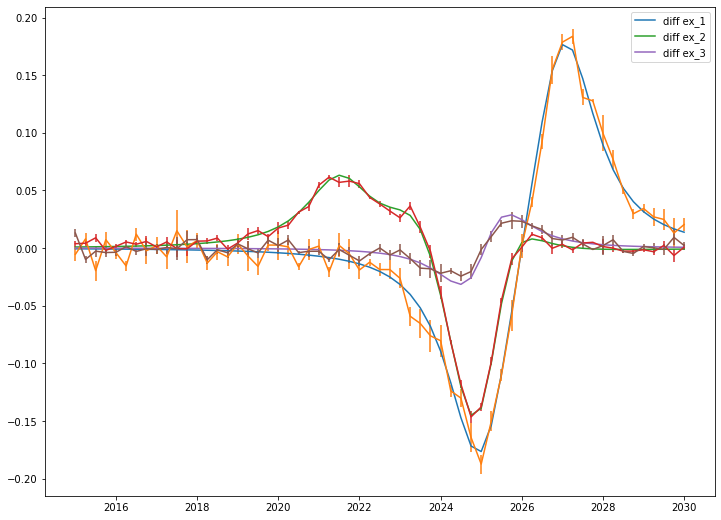

In [19]:
plt.figure(9)
plt.plot(e, ex_1-gs, label='diff ex_1')
plt.errorbar(e, sads_exp[0, :], sads_err[0, :])
plt.plot(e, ex_2-gs, label='diff ex_2')
plt.errorbar(e, sads_exp[1, :], sads_err[1, :])
plt.plot(e, ex_3-gs, label='diff ex_3')
plt.errorbar(e, sads_exp[2, :], sads_err[2, :])
plt.legend()
plt.show()

Experimental SADS is well matched to modeled SADS.

Note that SADS is the just linear combination of DADS

In [20]:
V_scale = np.einsum('j,ij->ij', c_exp, V_exp)
sads_from_dads = np.linalg.solve(V_scale.T, dads_exp)


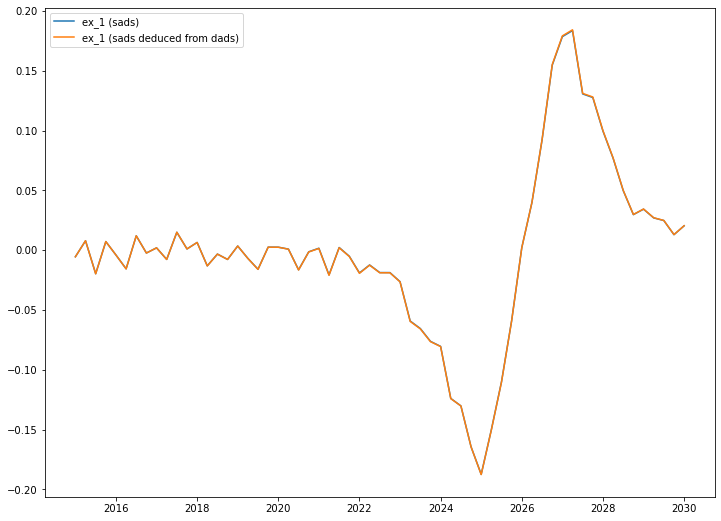

In [21]:
plt.figure(10)
plt.plot(e, sads_exp[0, :], label='ex_1 (sads)')
plt.plot(e, sads_from_dads[0, :], label='ex_1 (sads deduced from dads)')
plt.legend()
plt.show()

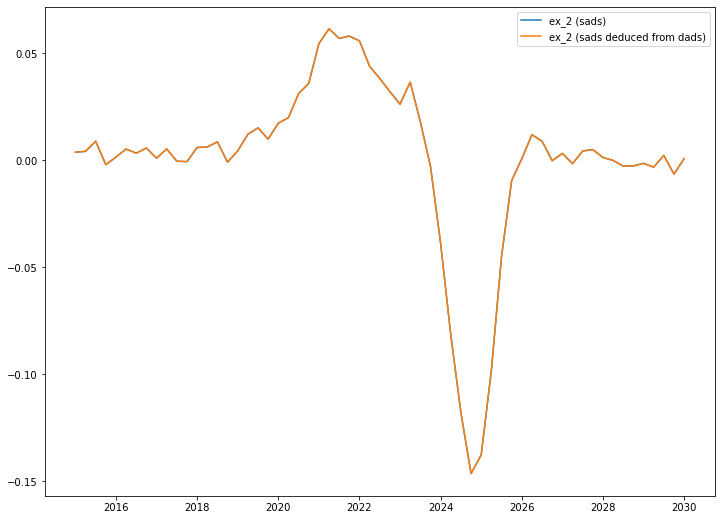

In [22]:
plt.figure(11)
plt.plot(e, sads_exp[1, :], label='ex_2 (sads)')
plt.plot(e, sads_from_dads[1, :], label='ex_2 (sads deduced from dads)')
plt.legend()
plt.show()

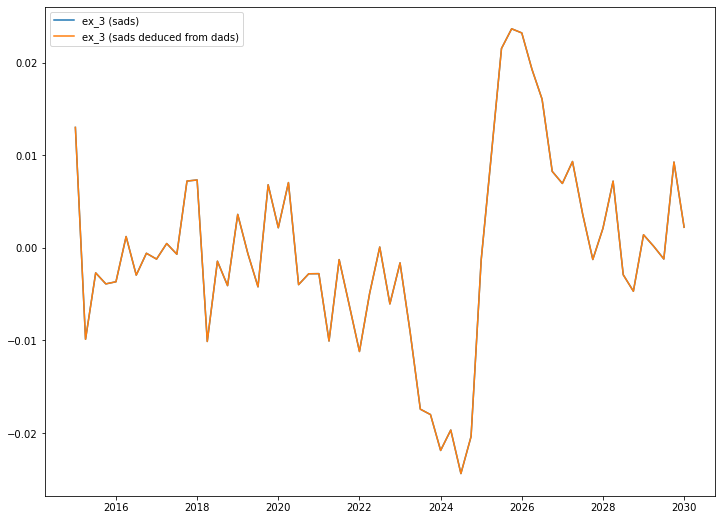

In [23]:
plt.figure(12)
plt.plot(e, sads_exp[2, :], label='ex_3 (sads)')
plt.plot(e, sads_from_dads[2, :], label='ex_3 (sads deduced from dads)')
plt.legend()
plt.show()